In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import paddle
# 导入训练数据
df_train = pd.read_csv("train.csv")
df_train = df_train.drop(['id'],axis=1)
# 对特征进行归一化
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(df_train.iloc[:,0:])  
scaler_data = scaler.transform(df_train.iloc[:,0:])
# 将训练数据集和测试数据集按照8:2的比例分开
ratio = 0.8
offset = int(df_train.shape[0] * ratio)
train_data = np.c_[scaler_data,df_train.iloc[:,0]][:offset].copy()
test_data = np.c_[scaler_data,df_train.iloc[:,0]][offset:].copy()

Index(['win', 'kills', 'deaths', 'assists', 'largestkillingspree',
       'largestmultikill', 'longesttimespentliving', 'doublekills',
       'triplekills', 'quadrakills', 'pentakills', 'totdmgdealt',
       'magicdmgdealt', 'physicaldmgdealt', 'truedmgdealt', 'largestcrit',
       'totdmgtochamp', 'magicdmgtochamp', 'physdmgtochamp', 'truedmgtochamp',
       'totheal', 'totunitshealed', 'dmgtoturrets', 'timecc', 'totdmgtaken',
       'magicdmgtaken', 'physdmgtaken', 'truedmgtaken', 'wardsplaced',
       'wardskilled', 'firstblood'],
      dtype='object')


In [38]:
# MLP模型组网搭建
n_input = 30
from paddle import nn
class Classifier(paddle.nn.Layer):
    def __init__(self):
        super(Classifier, self).__init__()
        self.l1 = paddle.nn.Linear(n_input, 1,)

    def forward(self, inputs):
        pred = self.l1(inputs)
        return pred


In [39]:
import paddle.nn.functional as F 
y_preds = []
train_nums = []
train_costs = []
labels_list = []
BATCH_SIZE = 20

def train(model):
    print('start training ... ')
    # 开启模型训练模式
    model.train()
    EPOCH_NUM = 5
    train_num = 0
    optimizer = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(train_data)
        # 将训练数据进行拆分，每个batch包含20条数据
        mini_batches = [train_data[k: k+BATCH_SIZE] for k in range(0, len(train_data), BATCH_SIZE)]
        for batch_id, data in enumerate(mini_batches):
            features_np = np.array(data[:, :n_input], np.float32)
            labels_np = np.array(data[:, -1:], np.float32)
            features = paddle.to_tensor(features_np)
            labels = paddle.to_tensor(labels_np)
            # 前向计算
            y_pred = model(features)
            cost = F.mse_loss(y_pred, label=labels)
            train_cost = cost.numpy()[0]
            # 反向传播
            cost.backward()
            # 最小化loss，更新参数
            optimizer.step()
            # 清除梯度
            optimizer.clear_grad()
            
            if batch_id%30 == 0 and epoch_id%50 == 0:
                print("Pass:%d,Cost:%0.5f"%(epoch_id, train_cost))

            train_num = train_num + BATCH_SIZE
            train_nums.append(train_num)
            train_costs.append(train_cost)
        
model = Classifier()
train(model)

start training ... 
Pass:0,Cost:1.64892
Pass:0,Cost:1.70996
Pass:0,Cost:0.82808
Pass:0,Cost:1.06871
Pass:0,Cost:1.26932
Pass:0,Cost:0.36407
Pass:0,Cost:0.48923
Pass:0,Cost:0.69038
Pass:0,Cost:1.16748
Pass:0,Cost:0.48667
Pass:0,Cost:0.32061
Pass:0,Cost:0.50801
Pass:0,Cost:0.49127
Pass:0,Cost:0.77959
Pass:0,Cost:0.24992
Pass:0,Cost:0.41158
Pass:0,Cost:0.57962
Pass:0,Cost:0.21543
Pass:0,Cost:0.26191
Pass:0,Cost:0.11424
Pass:0,Cost:0.15846
Pass:0,Cost:0.17296
Pass:0,Cost:0.21713
Pass:0,Cost:0.33425
Pass:0,Cost:0.13636
Pass:0,Cost:0.10134
Pass:0,Cost:0.12961
Pass:0,Cost:0.09740
Pass:0,Cost:0.12857
Pass:0,Cost:0.15691
Pass:0,Cost:0.09825
Pass:0,Cost:0.08822
Pass:0,Cost:0.07738
Pass:0,Cost:0.12253
Pass:0,Cost:0.07916
Pass:0,Cost:0.16457
Pass:0,Cost:0.03725
Pass:0,Cost:0.05173
Pass:0,Cost:0.09931
Pass:0,Cost:0.09538
Pass:0,Cost:0.10207
Pass:0,Cost:0.03770
Pass:0,Cost:0.06988
Pass:0,Cost:0.05353
Pass:0,Cost:0.09008
Pass:0,Cost:0.04047
Pass:0,Cost:0.07170
Pass:0,Cost:0.03304
Pass:0,Cost:0.04270


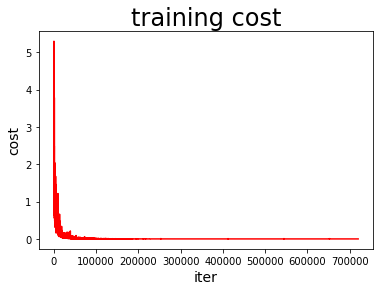

In [41]:
def draw_train_process(iters, train_costs):
    plt.title("training cost", fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs, color='red', label='training cost')
    plt.show()


import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
draw_train_process(train_nums, train_costs)

In [2]:
import os
import numpy as np
from paddle.io import Dataset

class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """
    def __init__(self, x, y):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        super(MyDataset, self).__init__()
        self.data_list = []
        for i,j in zip(x,y):
            self.data_list.append([i,j])

    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        data = self.data_list[index]
        feature = np.array(data[:-1]).astype('float32')
        label = np.array(data[-1:]).astype('int64')
        # 返回特征和对应标签
        return feature, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        return len(self.data_list)

train_dataset = MyDataset(x_train,y_train)
test_dataset = MyDataset(x_test,y_test)
train_dataset[0]

(array([[-1.0423225 , -0.24851945, -1.0652921 , -1.0532238 , -0.43834025,
         -0.19826205, -0.58423096, -0.24698801, -0.09784286, -0.04000573,
         -1.188272  , -0.7809258 , -0.6200115 , -0.28191438, -0.5774179 ,
         -1.2297674 , -0.8086368 , -0.564268  , -0.61155623, -0.82438904,
         -0.10260557, -0.7286519 ,  0.        , -1.2983824 , -1.155188  ,
         -1.1353154 , -0.51228553, -0.9952254 , -0.35158026, -0.33337447]],
       dtype=float32),
 array([0], dtype=int64))

In [11]:
# 来自https://www.baidu.com/link?url=hSEYSblNYfUpxy02rFPNyzfM9tGUUYgq2l09k759J-Fi-MjmmTuYPr9t52EHkXDjpZUiRMvEDoAtNpwfLCPFIKXW9G-QxvS6nc2RaXygDha&wd=&eqid=f4215a8e000bfe7e0000000662f6893c
class MyNet(paddle.nn.Layer):
    def __init__(self):
        super(MyNet,self).__init__()
        self.fc = paddle.nn.Linear(in_features=21, out_features=512)

        self.emb1 = paddle.nn.Linear(in_features=10,out_features=2048)
        self.emb2 = paddle.nn.Linear(in_features=2048,out_features=512)

        self.out = paddle.nn.Linear(in_features=1024,out_features=2)

    def forward(self,data,emb_data):
        x = self.fc(data)

        emb = self.emb1(emb_data)
        emb = self.emb2(emb)

        x = paddle.concat([x,emb],axis=-1)

        x = self.out(x)
        
        x = paddle.nn.functional.sigmoid(x)
        return x

In [10]:
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=1000,
    shuffle=True,
    drop_last=False)

In [13]:
model = MyNet()

max_epoch=10
opt = paddle.optimizer.SGD(learning_rate=0.1, parameters=model.parameters())

# 训练
now_step=0
for epoch in range(max_epoch):
    for step, data in enumerate(train_dataloader):
        now_step+=1

        data,emb_data, label = data
        pre = model(data,emb_data)
        loss = paddle.nn.functional.cross_entropy(pre,label,weight=paddle.to_tensor([0.2,1.0]),reduction='mean')
        # loss = paddle.nn.functional.square_error_cost(pre,label.reshape([-1,1]).astype('float32'))
        # loss = paddle.mean(loss)
        loss.backward()
        opt.step()
        opt.clear_gradients()
        if now_step%1==0:
            print("epoch: {}, batch: {}, loss is: {}".format(epoch, step, loss.mean().numpy()))

# 保存模型到model.pdparams
paddle.save(model.state_dict(), 'model.pdparams')

ValueError: not enough values to unpack (expected 3, got 2)

In [8]:

# paddle.device.set_device('gpu:0')  # 本地显卡MX150没装CUDA
# 封装模型为一个 model 实例，便于进行后续的训练、评估和推理
model = paddle.Model(lenet_Sequential)
# 为模型训练做准备，设置优化器及其学习率，并将网络的参数传入优化器，设置损失函数和精度计算方式
model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters()), 
              loss=paddle.nn.MSELoss(), 
              metrics=paddle.metric.Accuracy())
# 启动模型训练，指定训练数据集，设置训练轮次，设置每次数据集计算的批次大小，设置日志格式
model.fit(train_dataset, 
          test_dataset,
          epochs=1, 
          batch_size=1,
          verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/1


ValueError: (InvalidArgument) The type of data we are trying to retrieve does not match the type of data currently contained in the container.
  [Hint: Expected dtype() == paddle::experimental::CppTypeToDataType<T>::Type(), but received dtype():7 != paddle::experimental::CppTypeToDataType<T>::Type():12.] (at C:\home\workspace\Paddle_release\paddle\phi\core\dense_tensor.cc:137)
  [operator < elementwise_sub > error]

0.8472
